# GSE138181
## Xiaonan Wang
## 14Nov2022

In [2]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.7.1 anndata==0.7.8 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6


# Data in

In [3]:
FileDir = '/nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE138181/'

In [4]:
Files = [x for x in listdir(FileDir) if 'GSM' in x]
print(Files)
GSM = np.unique([x.split('_')[0] for x in Files])
print(GSM)
print(len(GSM))

['GSM4101380_587680_45_raw_gene_bc_matrices_h5.h5', 'GSM4101381_587680_46_raw_gene_bc_matrices_h5.h5', 'GSM4101382_587680_47_raw_gene_bc_matrices_h5.h5']
['GSM4101380' 'GSM4101381' 'GSM4101382']
3


In [5]:
# sorted either mCherry+(kdrl) or/and Citrine+(runx1) cells
meta = pd.DataFrame([['GSM4101380', 'na', 'adult', 'Healthy', '0', 'Tg(kdrl:Hsa.HRAS-mCherry);TgBAC(runx1P2:Citrine)', 'ventricle', 'GSE138181', 'mCherry+Citrine+ cells', 'WT', 'Danio rerio', 'mixed', 'Koth'],
                   ['GSM4101381', 'na', 'adult', 'Injured', '3', 'Tg(kdrl:Hsa.HRAS-mCherry);TgBAC(runx1P2:Citrine)', 'ventricle', 'GSE138181', 'mCherry+Citrine+ cells', 'WT', 'Danio rerio', 'mixed', 'Koth'],
                     ['GSM4101382', 'na', 'adult', 'Injured', '3', 'Tg(kdrl:Hsa.HRAS-mCherry);TgBAC(runx1P2:Citrine)runx1W84X', 'ventricle', 'GSE138181', 'mCherry+Citrine+ cells', 'runx1-/-', 'Danio rerio', 'mixed', 'Koth']
                    ], columns = ['Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author'])

In [6]:
adata = []
for idx, row in meta.iterrows():
    FN = [x for x in Files if row['Index'] in x][0]
    print(FN)
    adata_sub = sc.read_10x_h5(FileDir+FN)
    adata_sub.obs['Index'] = row['Index']
    adata_sub.obs['Age'] = row['Age']
    adata_sub.obs['Development_stage'] = row['Development_stage']
    adata_sub.obs['Condition'] = row['Condition']
    adata_sub.obs['Day'] = row['Day']
    adata_sub.obs['Strain'] = row['Strain']
    adata_sub.obs['Tissue'] = row['Tissue']
    adata_sub.obs['StudyID'] = row['StudyID']
    adata_sub.obs['CellType'] = row['CellType']
    adata_sub.obs['Genotype'] = row['Genotype']
    adata_sub.obs['Organism'] = row['Organism']
    adata_sub.obs['Gender'] = row['Gender']
    adata_sub.obs['Author'] = row['Author']
    adata_sub.var_names_make_unique()
    adata.append(adata_sub)
    del adata_sub

reading /nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE138181/GSM4101380_587680_45_raw_gene_bc_matrices_h5.h5


GSM4101380_587680_45_raw_gene_bc_matrices_h5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
reading /nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE138181/GSM4101381_587680_46_raw_gene_bc_matrices_h5.h5


GSM4101381_587680_46_raw_gene_bc_matrices_h5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
reading /nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE138181/GSM4101382_587680_47_raw_gene_bc_matrices_h5.h5


GSM4101382_587680_47_raw_gene_bc_matrices_h5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)


In [7]:
adata

[AnnData object with n_obs × n_vars = 737280 × 26977
     obs: 'Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author'
     var: 'gene_ids',
 AnnData object with n_obs × n_vars = 737280 × 26977
     obs: 'Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author'
     var: 'gene_ids',
 AnnData object with n_obs × n_vars = 737280 × 26977
     obs: 'Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author'
     var: 'gene_ids']

# QC

In [8]:
[x for x in adata[0].var_names if x.startswith('mt-')]

['mt-nd1',
 'mt-nd2',
 'mt-co1',
 'mt-co2',
 'mt-atp8',
 'mt-atp6',
 'mt-co3',
 'mt-nd3',
 'mt-nd4l',
 'mt-nd4',
 'mt-nd5',
 'mt-nd6',
 'mt-cyb']

In [9]:
for i in range(len(adata)):
    sc.pp.filter_cells(adata[i], min_genes=100)

filtered out 732560 cells that have less than 100 genes expressed
filtered out 732526 cells that have less than 100 genes expressed
filtered out 731012 cells that have less than 100 genes expressed


In [10]:
for i in range(len(adata)):
    adata[i].var['mt'] = adata[i].var_names.str.startswith('mt-') 
    sc.pp.calculate_qc_metrics(adata[i], qc_vars=['mt'], inplace=True)

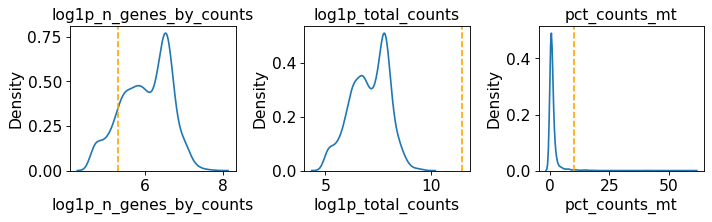

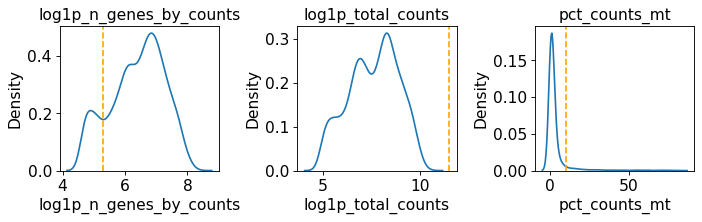

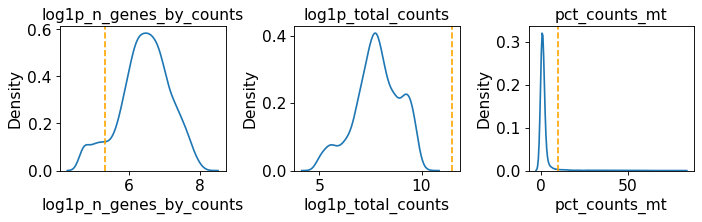

In [11]:
cutoffs = [[200,100000, np.exp(10)],
           [200,100000, np.exp(10)],
           [200,100000, np.exp(10)]
           ]
for i in range(len(adata)):
    obs_terms = ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt']
    fig,ax = plt.subplots(1,3, figsize=(9,3))
    for j in range(len(obs_terms)):
        sns.kdeplot(adata[i].obs[obs_terms[j]], ax=ax[j])
        ax[j].grid(False)
        ax[j].set_title(obs_terms[j])
        ax[j].axvline(np.log1p(cutoffs[i][j]), c='orange', linestyle='--')
    plt.tight_layout()

In [12]:
for i in range(len(adata)):
    sc.pp.filter_cells(adata[i], min_genes=cutoffs[i][0])
    #sc.pp.filter_genes(adata[i], min_cells=1)
    adata[i] = adata[i][(adata[i].obs['total_counts'] <= cutoffs[i][1]) & (adata[i].obs['pct_counts_mt'] <= np.log(cutoffs[i][2])), :].copy()
    print(adata[i].obs['Condition'].value_counts().sort_index())

filtered out 642 cells that have less than 200 genes expressed
filtered out 687 cells that have less than 200 genes expressed
filtered out 525 cells that have less than 200 genes expressed


Healthy    4059
Name: Condition, dtype: int64
Injured    3916
Name: Condition, dtype: int64
Injured    5661
Name: Condition, dtype: int64


In [13]:
for i in range(len(adata)):
    print(adata[i].shape)

(4059, 26977)
(3916, 26977)
(5661, 26977)


In [14]:
#combine and save the raw counts
adata1 = anndata.AnnData.concatenate(*adata) #, join='outer', fill_value=0

In [15]:
adata1.shape

(13636, 26977)

In [16]:
sc.pp.filter_genes(adata1, min_cells=1)

filtered out 6156 genes that are detected in less than 1 cells


In [18]:
adata1.write('./write/GSE138181_raw.h5ad')

# Normalisation

In [20]:
adata = sc.read('./write/GSE138181_raw.h5ad')

In [21]:
print(adata.shape)

(13636, 20821)


In [22]:
# normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [23]:
# log counts
sc.pp.log1p(adata)

In [24]:
adata.raw = adata

In [25]:
print(adata.shape)

(13636, 20821)


In [26]:
adata.write('./write/GSE138181_lognorm.h5ad')

# Cell Cycle Assignment

In [27]:
adata = sc.read('./write/GSE138181_lognorm.h5ad')

In [28]:
print(adata.shape)

(13636, 20821)


In [29]:
cell_cycle_genes = [x.strip()[0].upper()+x.strip()[1:].lower() for x in open('/nfs01data1/Groups/Wangxiaonan/Lab_members/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [30]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print(len(s_genes))
print(len(g2m_genes))

43
54


In [31]:
GN = pd.read_csv('../drerio_mmusculus.txt', delimiter='\t', index_col=0)

In [32]:
GN.head(3)

,external_gene_name,mmusculus_homolog_ensembl_gene,mmusculus_homolog_associated_gene_name
ensembl_gene_id,,,
ENSDARG00000063344,fam162a,ENSMUSG00000019909,Fam162b
ENSDARG00000097685,si:ch211-235i11.3,NaN,NaN
ENSDARG00000036008,caly,ENSMUSG00000025468,Caly


In [33]:
SGo = np.intersect1d(s_genes, [str(x) for x in GN['mmusculus_homolog_associated_gene_name']])
Stab = GN[np.in1d([str(x) for x in GN['mmusculus_homolog_associated_gene_name']], SGo)]
G2Mo = np.intersect1d(g2m_genes, [str(x) for x in GN['mmusculus_homolog_associated_gene_name']])
G2Mtab = GN[np.in1d([str(x) for x in GN['mmusculus_homolog_associated_gene_name']], G2Mo)]

In [34]:
sg_drerio = np.unique([str(x) for x in Stab['external_gene_name']])
g2mg_drerio = np.unique([str(x) for x in G2Mtab['external_gene_name']])
print(len(sg_drerio))
print(len(g2mg_drerio))

40
51


In [35]:
sg_drerio_ol = np.intersect1d(sg_drerio, adata.raw.var_names)
g2mg_drerio_ol = np.intersect1d(g2mg_drerio, adata.raw.var_names)
print(len(sg_drerio_ol))
print(len(g2mg_drerio_ol))

39
51


In [36]:
Index = adata.obs['Index'].cat.categories
print(Index)

Index(['GSM4101380', 'GSM4101381', 'GSM4101382'], dtype='object')


In [37]:
phase = []
for i in range(len(Index)):
    adata_sub = adata[adata.obs['Index'] == Index[i]].copy()
    print(adata_sub.shape)
    sc.pp.scale(adata_sub)
    sc.tl.score_genes_cell_cycle(adata_sub, s_genes=sg_drerio, g2m_genes=g2mg_drerio, use_raw=False)
    phase.append(adata_sub.obs[['phase', 'S_score', 'G2M_score']])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(4059, 20821)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    678 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    717 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(3916, 20821)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    640 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    719 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(5661, 20821)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    758 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    759 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [38]:
phase_pd = pd.concat(phase)

In [39]:
phase_pd.head()

,phase,S_score,G2M_score
AAACCTGCAATCAGAA-1-0,S,0.106424,0.007809
AAACCTGCAGCTGCAC-1-0,G1,-0.076226,-0.065720
AAACCTGCATCCTTGC-1-0,G1,-0.036389,-0.028713
AAACCTGCATTGGTAC-1-0,G1,-0.082940,-0.086500
AAACCTGTCTCAAACG-1-0,G1,-0.204451,-0.219045


In [40]:
phase_pd.to_csv('cell_cycle_results.txt')

# Select highly variable genes

In [41]:
adata = sc.read('./write/GSE138181_lognorm.h5ad')

In [42]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [43]:
adata.obs.head(3)

,Index,Age,Development_stage,Condition,Day,Strain,Tissue,StudyID,CellType,Genotype,...,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,batch,n_counts,phase,S_score,G2M_score
AAACCTGCAATCAGAA-1-0,GSM4101380,na,adult,Healthy,0,Tg(kdrl:Hsa.HRAS-mCherry);TgBAC(runx1P2:Citrine),ventricle,GSE138181,mCherry+Citrine+ cells,WT,...,88.861386,100.0,1.0,0.693147,0.123762,0,808.0,S,0.106424,0.007809
AAACCTGCAGCTGCAC-1-0,GSM4101380,na,adult,Healthy,0,Tg(kdrl:Hsa.HRAS-mCherry);TgBAC(runx1P2:Citrine),ventricle,GSE138181,mCherry+Citrine+ cells,WT,...,88.417746,100.0,13.0,2.639057,0.510404,0,2547.0,G1,-0.076226,-0.065720
AAACCTGCATCCTTGC-1-0,GSM4101380,na,adult,Healthy,0,Tg(kdrl:Hsa.HRAS-mCherry);TgBAC(runx1P2:Citrine),ventricle,GSE138181,mCherry+Citrine+ cells,WT,...,88.141026,100.0,14.0,2.708050,2.243590,0,624.0,G1,-0.036389,-0.028713


In [44]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)

extracting highly variable genes
... storing 'phase' as categorical
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


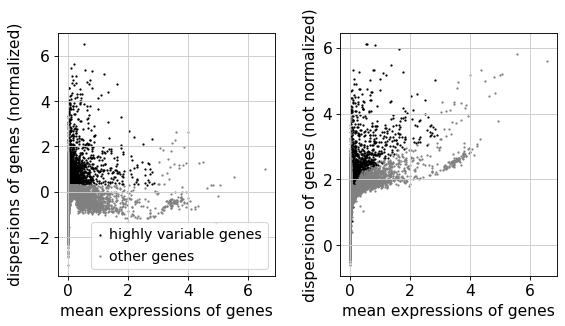

In [45]:
sc.pl.highly_variable_genes(adata)

In [46]:
print(np.sum(adata.var.highly_variable))

5001


In [47]:
adata = adata[:, adata.var.highly_variable].copy()

In [48]:
adata.write('./write/GSE138181_lognorm_hvg.h5ad')

# Preliminary processing

In [49]:
adata = sc.read('./write/GSE138181_lognorm_hvg.h5ad')

In [50]:
# normally regress out the top layers of unwanted effects
sc.pp.regress_out(adata, ['total_counts','n_genes_by_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:02:15)


In [51]:
# scale for pca
sc.pp.scale(adata)
# pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


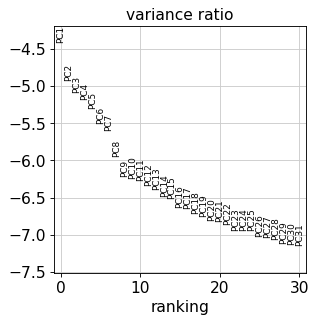

In [52]:
sc.pl.pca_variance_ratio(adata, log=True)

In [53]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)


In [54]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


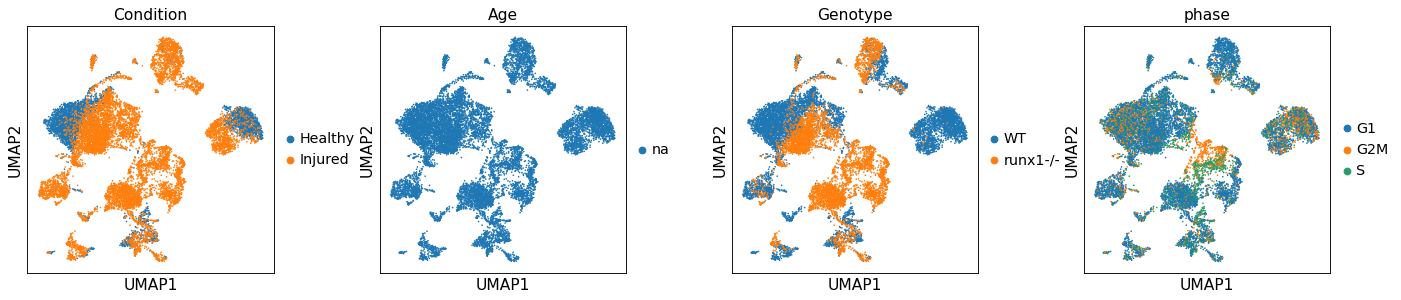

In [55]:
sc.pl.umap(adata, color= ['Condition', 'Age', 'Genotype', 'phase'], wspace=0.3)

In [56]:
adata.write('./write/GSE138181_processed.h5ad')